# Image segmentation


* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
In the last two decades, as the spatial resolution of satellite images has increased, remote sensing has begun to shift from a focus on pixel-based analysis towards Geographic Object-Based Image Analysis (GEOBIA), which aims to group pixels together into meaningful image-objects. 
There are two advantages to a GEOBIA worklow; one, we can reduce the 'salt and pepper' effect typical of classifying pixels; and two, we can increase the computational efficiency of our workflow by grouping pixels into fewer, larger, but meaningful objects. 
A review of the emerging trends in GEOBIA can be found in [Chen et al. (2017)](https://www.tandfonline.com/doi/abs/10.1080/15481603.2018.1426092).

## Description
This notebook demonstrates a method for conducting `image segmentation`, which is a common image analysis technique used to transform a digital satellite image into objects. 
In brief, [image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) aims to partition an image into segments, where each segment consists of a group of pixels with similar characteristics. 
Here we use the [Quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift) algorithm, implemented through the python package `scikit-image`, to perform the image segmentation.



## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
from osgeo import gdal
from datacube.utils.cog import write_cog
from skimage.segmentation import quickshift

from deafrica_tools.plotting import display_map
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard, mostcommon_crs, array_to_geotiff

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Image_segmentation')


### Analysis parameters

In [3]:
lat, lon = -31.704, 18.523
buffer = 0.03

x = (lon - buffer, lon + buffer)
y =  (lat + buffer, lat - buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2018-01', '2018-03'),
    'resolution': (-30, 30)
}

### View the selected location

In [4]:
display_map(x=x, y=y)

## Load Sentinel-2 data from the datacube

Here we are loading in a timeseries of `Sentinel-2` satellite images through the datacube API using the [load_ard](../Frequently_used_code/Using_load_ard.ipynb) function. This will provide us with some data to work with.

In [5]:
#find the most common UTM crs for the location
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)

# Load available data
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              measurements=['red', 'nir_1', 'swir_1', 'swir_2'],
              group_by='solar_day',
              output_crs=output_crs, 
              **query)

# Print output data
print(ds)


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 35 time steps
<xarray.Dataset>
Dimensions:      (time: 35, y: 227, x: 195)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T08:42:22 ... 2018-03-30T08:...
  * y            (y) float64 6.493e+06 6.493e+06 ... 6.486e+06 6.486e+06
  * x            (x) float64 2.623e+05 2.624e+05 ... 2.681e+05 2.682e+05
    spatial_ref  int32 32734
Data variables:
    red          (time, y, x) float32 3.387e+03 2.899e+03 ... 1.366e+03
    nir_1        (time, y, x) float32 4.423e+03 3.662e+03 ... 2.583e+03
    swir_1       (time, y, x) float32 6.469e+03 5.326e+03 ... 3.069e+03
    swir_2       (time, y, x) float32 5.309e+03 4.276e+03 ... 2.153e+03
Attributes:
    crs:           epsg:32734
    grid_mapping:  spatial_ref


## Combine observations into a noise-free statistical summary image
Individual remote sensing images can be affected by noisy and incomplete data (e.g. due to clouds). To produce cleaner images that we can feed into the image segmentation algorithm, we can create summary images, or `composites`, that combine multiple images into one image to reveal the 'typical' appearance of the landscape for a certain time period.  In the code below, we take the noisy, incomplete satellite images we just loaded and calculate the mean `Normalised Difference Vegetation Index (NDVI)`.  The mean NDVI will be our input into the segmentation algorithm.

### Calculate mean NDVI

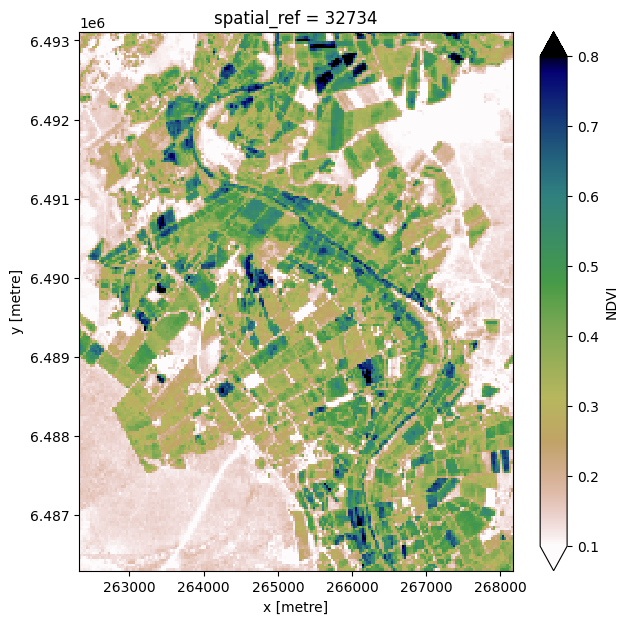

In [6]:
# First we calculate NDVI on each image in the timeseries
ndvi = calculate_indices(ds, index='NDVI', satellite_mission='s2')

# For each pixel, calculate the mean NDVI throughout the whole timeseries
ndvi = ndvi.mean(dim='time', keep_attrs=True)

# Plot the results to inspect
ndvi.NDVI.plot(vmin=0.1, vmax=0.8, cmap='gist_earth_r', figsize=(7, 7))


## Quickshift Segmentation

Using the function [quickshift](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift) from the python package `scikit-image`, we will conduct an image segmentation on the mean NDVI array.  We then calculate a zonal mean across each segment using the input dataset. Our last step is to export our results as a GeoTIFF.

Follow the quickshift hyperlink above to see the input parameters to the algorithm, and the following [link](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html) for an explanation of quickshift and other segmentation algorithms in `scikit-image`.

In [7]:
# Convert our mean NDVI xarray into a numpy array, we need
# to be explicit about the datatype to satisfy quickshift
input_array = ndvi.NDVI.values.astype(np.float64)


In [8]:
# Calculate the segments
segments = quickshift(input_array,
                      kernel_size=1,
                      convert2lab=False,
                      max_dist=2,
                      ratio=1.0)


In [9]:
# Calculate the zonal mean NDVI across the segments
segments_zonal_mean_qs = scipy.ndimage.mean(input=input_array,
                                            labels=segments,
                                            index=segments)


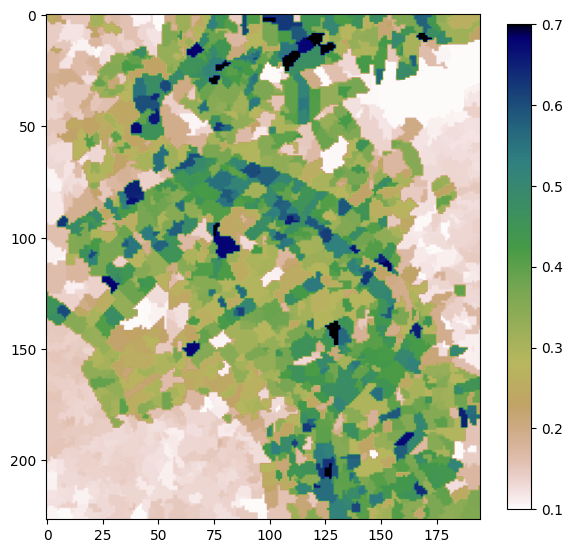

In [10]:
# Plot to see result
plt.figure(figsize=(7,7))
plt.imshow(segments_zonal_mean_qs, cmap='gist_earth_r', vmin=0.1, vmax=0.7)
plt.colorbar(shrink=0.9)


### Export result to GeoTIFF
See this [notebook](../Frequently_used_code/Exporting_GeoTIFFs.ipynb) for more info on writing GeoTIFFs to file.

In [11]:
transform = ds.geobox.transform.to_gdal()
projection = ds.geobox.crs.wkt

# Export the array
array_to_geotiff('segmented_meanNDVI_QS.tif',
                  segments_zonal_mean_qs,
                  geo_transform=transform,
                  projection=projection,
                  nodata_val=np.nan)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.12


**Last Tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-03-30'